In [1]:
%load_ext autoreload
from tensorboardX import SummaryWriter  
from IPython.core.debugger import set_trace
import os
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torchvision
import torchio as tio
from models.v2v import V2VModel
import matplotlib.pyplot as plt
import yaml
from easydict import EasyDict as edict
from utils import video_comparison, video, get_capacity
from celluloid import Camera
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
from utils import DiceScoreBinary, DiceLossBinary
from datasets import create_datasets
%autoreload 2

/nfs/home/ibulygin/miniconda3/envs/fcd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Mon Mar  7 19:47:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   29C    P8     9W / 280W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [33]:
MAKE_LOGS = False
SAVE_MODEL = False
DEVICE = 0
TASK='patchseg'
DATASET = 'BRATS' #'BRATS' # 'FCD'

In [11]:
logdir = './logs_segpatch/resnet3d_GRID_segpatch_ps64_FCD_bs1_pbs8_pov0.8_lr-1e-3@01.03.2022-03:36:08'
# logdir = './logs_segpatch/resnet3d_GRID_segpatch_ps64_BRATS_bs1_pbs8_pov0.9_lr-1e-3@01.03.2022-03:24:37'
# logdir = 'logs_clf/resnet3d_GRID_ps32_BRATS_bs1_pbs64_pov0.9_clf0.5_fcd0.5_lr-1e-3_AUG@18.02.2022-20:36:13'
# logdir = 'logs_clf/resnet3d_GRID_ps32_FCD_bs1_pbs64_pov0.9_clf0.5_fcd0.5_lr-1e-3_AUG@18.02.2022-20:35:37/'

In [12]:
os.listdir(logdir)

['tb', 'best_val_preds', 'config.yaml', 'checkpoints']

In [27]:
sorted(os.listdir(os.path.join(logdir, 'checkpoints')))

['weights_0.pth',
 'weights_1.pth',
 'weights_2.pth',
 'weights_3.pth',
 'weights_4.pth',
 'weights_5.pth',
 'weights_6.pth',
 'weights_7.pth',
 'weights_8.pth']

In [28]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

### Load model, setup dataloaders

In [35]:
device = torch.device(f'cuda:{DEVICE}')

# essential for the proper samplers functioning
assert config.opt.val_batch_size == 1
assert config.opt.train_batch_size == 1
assert config.dataset.sampler_type == 'grid'
assert config.dataset.shuffle_train == False

################
# CREATE MODEL #
################
if TASK=='clf':
    model = torchvision.models.video.r3d_18(pretrained=False, progress=False)
    conv3d_1 = model.stem[0]
    input_channels = len(config.dataset.features)
    model.stem[0] = nn.Conv3d(in_channels=input_channels,
                             out_channels=conv3d_1.out_channels,
                             kernel_size=conv3d_1.kernel_size,
                             padding=conv3d_1.padding,
                             bias=conv3d_1.bias)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model = model.to(device)
elif TASK=='patchseg':
    model = V2VModel(config).to(device)

model_capacity = get_capacity(model)
print(f'Model created! Capacity: {model_capacity}')
model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights_8.pth'), map_location=torch.device('cpu'))
print('LOADING from epoch:',model_dict['epoch'])
model.load_state_dict(model_dict['model_state'])

###################
# CREATE DATASETS #
###################
train_dataset, val_dataset = create_datasets(config)
collate_fn = None
train_dataloader = DataLoader(train_dataset,
                                batch_size=config.opt.train_batch_size,
                                shuffle=False,
                                collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=config.opt.val_batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)
print(len(train_dataloader), len(val_dataloader))

augmentation = None

################
# CREATE OPTIM #
################
criterion = {
    "BCE": nn.BCEWithLogitsLoss(),
    "Dice": DiceLossBinary
}[config.opt.criterion]

print('val dataloder len: ', len(val_dataloader), 'train dataloder len: ', len(train_dataloader))

Model created! Capacity: 11.82
LOADING from epoch: 8
56 7
val dataloder len:  7 train dataloder len:  56


In [36]:
len(val_dataloader)

7

### Load pre-calculated results

In [38]:
best_val_preds = {}
best_val_preds_dir = os.path.join(logdir, 'best_val_preds')
for label in os.listdir(best_val_preds_dir):
    best_val_preds_path = os.path.join(best_val_preds_dir, label)
    best_val_preds[label] = torch.load(best_val_preds_path)

### Forward pass

In [39]:
is_train = False
phase_name = 'val'
loss_name = config.opt.criterion
metric_dict = defaultdict(list)
patch_size = config.dataset.patch_size
patch_batch_size = config.dataset.patch_batch_size
batch_size = config.opt.train_batch_size if is_train else config.opt.val_batch_size
classification_threshold = config.model.classification_threshold
patch_fcd_threshold = config.dataset.patch_fcd_threshold 
labels = val_dataloader.dataset.labels
patch_overlap = config.dataset.patch_overlap
top_k_list = config.dataset.top_k_list if hasattr(config.dataset, 'top_k_list') else [10, 50, 100]
assert isinstance(top_k_list, list)
assert batch_size == 1

AttributeError: 'EasyDict' object has no attribute 'classification_threshold'

In [96]:
brains = []
fcd_tensor = []
fcd_tensor_pred = []
targets_ = []
probs_pred_ = []
targets_pred_ = []

pov = int(patch_size*patch_overlap) # take high overlap to avoid missing
if pov%2!=0:
    pov+=1

metric_dict = defaultdict(list)
# used to turn on/off gradients
with torch.no_grad():
    iterator = enumerate(val_dataloader)

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    #######################
    # ITERATE OVER BRAINS #
    #######################
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(iterator):
        
        subject_info = {}
        
#     for label in ['223']: # '071', '343', '055', 
        
#         index = val_dataloader.dataset.labels.index(label)
#         brain_tensor, mask_tensor, label_tensor = val_dataloader.dataset[index]
    
        ###########################
        # SETUP PATCH DATALOADERS #
        ###########################
        label = labels[iter_i]
        
        if label_tensor.sum() == 0:
            print(f'No label for {label}, skipping...')
            continue

        n_fcd = label_tensor.sum()
        subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor[0]), # [0]
                      label=tio.LabelMap(tensor=label_tensor[0]), # [0]
                      n_fcd=n_fcd)

        if is_train and (augmentation is not None):
            subject = augmentation(subject)

        grid_sampler = tio.inference.GridSampler(subject, patch_size, pov)
        patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=patch_batch_size)
        aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

        ########################
        # ITERATE OVER PATCHES #
        #############################################################################
        # number of FCD pixels in patch to be considered as target patch
        metric_dict_patch = defaultdict(list)
        targets_all = []
        probs_all = []
        preds_all = []
        print(f'Iterating for {label}, {len(patch_loader)}')
        for patch_i, patches_batch in enumerate(patch_loader):

            inputs = patches_batch['t1'][tio.DATA].to(device)  # [bs,C,p,p,p]
            targets = patches_batch['label'][tio.DATA].to(device) # [bs,1,p,p,p]
            n_fcd = patches_batch['n_fcd'].to(device).unsqueeze(1)

            # it is target crop if there is enough pixels percentage of the target
            targets_ = (targets.sum([-1,-2,-3]) / n_fcd) >= patch_fcd_threshold
            # it is target crop if there is enough pixels in patch
            targets_ += (targets.sum([-1,-2,-3]) / (patch_size**3)) >= patch_fcd_threshold
            targets_ = targets_.type(torch.float32)

            logits = model(inputs)
            loss = criterion(logits, targets_) # [bs,1], [bs,1]

            locations = patches_batch[tio.LOCATION]

            # casting back to patch
            outputs = torch.ones_like(targets)*logits[...,None,None,None].sigmoid() # [bs,1,p,p,p]
            aggregator.add_batch(outputs.detach(), locations)

            #####################
            # per-PATCH METRICS #
            #####################
            # map to and remove last dim
            targets_np = targets_.squeeze(-1).detach().cpu().numpy().astype(int) # [bs,]
            prob_pred_np = torch.sigmoid(logits.squeeze(-1)).detach().cpu().numpy() # [bs,]
            targets_pred_np = (prob_pred_np >= classification_threshold).astype(int)

            targets_all += list(targets_np)
            probs_all += list(prob_pred_np)
            preds_all += list(targets_pred_np)

            metric_dict_patch[f'{loss_name}'].append(loss.item())

        ##############################################################################
        class_balance = np.mean(targets_all)
        metric_dict['class_balance'].append(class_balance)
        print(f'Class_balance for {label} is {class_balance}!')
        if class_balance == 0:
            print('Skipping!')
            continue

        for k,v in metric_dict_patch.items():
            metric_dict[k].append(np.mean(v))

        targets_all=np.array(targets_all)
        probs_all=np.array(probs_all)
        preds_all=np.array(preds_all)

        accuracy = accuracy_score(targets_all, preds_all)
        precision = precision_score(targets_all, preds_all, zero_division=0)
        recall = recall_score(targets_all, preds_all, zero_division=0)
        roc_auc = roc_auc_score(targets_all, probs_all, average='samples')
        f1 = f1_score(targets_all, preds_all, average='weighted')

        metric_dict['accuracy'].append(accuracy)
        metric_dict['precision'].append(precision)
        metric_dict['recall'].append(recall)
        metric_dict['roc_auc_samples'].append(roc_auc)
        metric_dict['f1_weighted'].append(f1)

        ###########
        # HITRATE #
        ###########
        # sorting by predicted probabilities
        argsort = np.argsort(probs_all, axis=0)[::-1]
        for top_k in top_k_list:
            top_k_fcd = targets_all[argsort][:top_k]
            hitrate = top_k_fcd.mean()
            metric_dict[f'top-{top_k}_hitrate'].append(hitrate)

        ########
        # DICE #
        ########
        
        output_tensor = aggregator.get_output_tensor().unsqueeze(1) # [1,1,H,W,D]
        output_tensor = output_tensor * mask_tensor.unsqueeze(0) # zeros all non mask values
        dice = DiceScoreBinary(output_tensor, label_tensor).item()
        coverage = (output_tensor*label_tensor).sum() / label_tensor.sum()
        metric_dict['dice_score'].append(dice)
        metric_dict['coverage'].append(coverage.item())
        
        label_path = os.path.join(val_preds_path, label)
        
#         os.makedirs(label_path, exist_ok=True)
#         brain_path = os.path.join(label_path, f'brain')
#         label_path = os.path.join(label_path, f'label')
#         label_pred_path = os.path.join(label_pred_path, f'label_pred')
        
        subject_info['brain_tensor'] = brain_tensor[0].detach().cpu().numpy()
        subject_info['label_tensor'] = label_tensor[0].detach().cpu().numpy()
        subject_info['label_pred_tensor'] = output_tensor[0].detach().cpu().numpy()
        subject_info['targets_'] = targets_all
        subject_info['probs_pred_'] = probs_all
        subject_info['targets_pred_'] = preds_all
        
        np.save(label_path, subject_info)
        
#         brains.append()
#         fcd_tensor.append(label_tensor.detach().cpu().numpy())
#         fcd_tensor_pred.append(output_tensor[0].detach().cpu().numpy())
#         targets_.append(targets_all)
#         probs_pred_.append(probs_all)
#         targets_pred_.append(preds_all)


0it [00:00, ?it/s]

Iterating for n15, 1363
Class_balance for n15 is 0.0045754781890738954!


1it [24:43, 1483.68s/it]

Iterating for 30, 1859
Class_balance for 30 is 0.003135771332492644!


2it [58:32, 1804.56s/it]

Iterating for 49, 1829
Class_balance for 49 is 0.0011452991452991453!


3it [1:31:54, 1894.73s/it]

Iterating for 41, 1829
Class_balance for 41 is 0.002547008547008547!


4it [2:05:11, 1934.96s/it]

Iterating for n11, 1363
Class_balance for n11 is 0.00448373927801477!


5it [2:30:02, 1774.97s/it]

Iterating for 10, 1829
Class_balance for 10 is 0.0020683760683760685!


6it [3:03:18, 1850.14s/it]

Iterating for n5, 1363
Class_balance for n5 is 0.004541076097426724!


7it [3:28:09, 1784.22s/it]


In [97]:
labels

['n15', '30', '49', '41', 'n11', '10', 'n5']

In [35]:
dices = []
for label in tqdm(os.listdir(val_preds_path)):
    label_path = os.path.join(val_preds_path, f'{label}') # .npy
    subj = np.load(label_path, allow_pickle=True).item()
    
    brain_tensor = subj['brain_tensor']
    label_tensor = subj['label_tensor']
    output_tensor = subj['label_pred_tensor']
    
    dice = DiceScoreBinary(torch.tensor(output_tensor), torch.tensor(label_tensor).unsqueeze(0)).item()
    dices.append(dice)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:32<00:00,  2.80it/s]


In [36]:
dices

[0.3786092698574066,
 0.7133114337921143,
 0.25817304849624634,
 0.6924889087677002,
 8.823032658256125e-06,
 0.34630367159843445,
 0.621406078338623,
 0.7800419330596924,
 0.2762298882007599,
 0.05473322048783302,
 0.025721270591020584,
 0.3090061545372009,
 0.45649972558021545,
 0.16619367897510529,
 0.42045366764068604,
 0.004819102585315704,
 0.21016471087932587,
 0.33514025807380676,
 0.49870941042900085,
 0.0019196138018742204,
 0.2410535365343094,
 0.39631104469299316,
 0.7786048054695129,
 0.6518704891204834,
 0.6327648162841797,
 0.09495936334133148,
 0.7876228094100952,
 0.01617720164358616,
 0.20075896382331848,
 0.7485408186912537,
 0.3236974775791168,
 0.03162708505988121,
 0.2882024049758911,
 0.23200322687625885,
 0.26421892642974854,
 0.047776252031326294,
 0.13895855844020844,
 0.7222489714622498,
 0.30795279145240784,
 0.4723092317581177,
 0.21532781422138214,
 0.5546203851699829,
 0.44211775064468384,
 0.3857523798942566,
 0.6787520051002502,
 0.7842254042625427,
 0.

In [37]:
val_labels = [p.split('.')[0] for p in os.listdir(val_preds_path)]

In [27]:
val_labels

['n5', '49', '10', '41', '30', 'n11', 'n15']

In [19]:
output_tensor.shape, label_tensor.shape

((1, 1, 183, 235, 199), (1, 183, 235, 199))

In [124]:
brain_tensor.shape, label_tensor.shape

((10, 183, 235, 199), (1, 183, 235, 199))

In [125]:
plt.ioff()
camera = video_comparison([brain_tensor[0], 
                           brain_tensor[0]], 
              [label_tensor[0], 
               output_tensor[0,0]], 
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [11]:
# for brain in brains:
#     N = len(brain)
#     fig, ax = plt.subplots(1,N, sharex=True, sharey=True)
#     X_max, Y_max, Z_max = brain[0].shape
#     for i,ax in enumerate(ax):
#         brain_slice = brain[i][:,Y_max//2,:]
#         ax.imshow(brain_slice)
#     plt.show()

In [12]:
coverages

[0.004367941990494728,
 0.004287193529307842,
 0.004106511827558279,
 0.003701212350279093,
 0.002620510058477521,
 0.0038791990373283625,
 0.0030463605653494596]

In [13]:
dices

[0.003112341044470668,
 0.0031131398864090443,
 0.005603819619864225,
 0.0038454721216112375,
 0.0006429022760130465,
 0.0060189287178218365,
 0.0011410253355279565]

In [14]:
np.mean(dices)

0.0033539470002454308

Hard examples:



In [6]:
# train_labels = train_dataloader.dataset.labels
# train_dices = dict(zip(train_labels, dices))
# np.save(os.path.join(logdir, 'train_dices'), train_dices)

In [7]:
# dices_tsc = dices

In [8]:
# plt.figure(figsize=(25,5))
# plt.bar(train_labels, dices_ng, alpha=0.5, label='No geom')
# plt.bar(train_labels, dices_tsc, alpha=0.5, label='with TSC')
# exp_name = logdir.split('/')[1]
# plt.title(f'Training')
# plt.ylabel('Dice score')
# plt.legend()
# plt.xticks(rotation=90)
# plt.show()

In [28]:
# val_labels = val_dataloader.dataset.labels
# val_dices = dict(zip(val_labels, dices))
# np.save(os.path.join(logdir, 'val_dices'), val_dices)

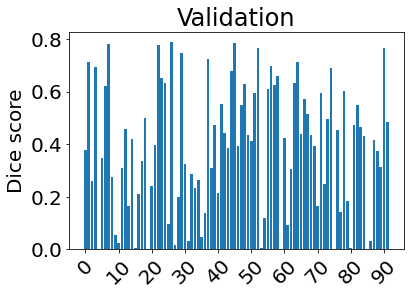

In [44]:
plt.ion()
plt.figure()
plt.bar(val_labels, dices)
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Dice score')
plt.xticks(np.arange(0,len(val_labels),10),
          np.arange(0,len(val_labels),10), 
           rotation=45)
plt.show()

In [13]:
# plt.bar(val_labels, dices, alpha=0.5, label='No geom')
# plt.bar(val_labels, dices_tsc, alpha=0.5, label='with TSC')

# exp_name = logdir.split('/')[1]
# plt.title(f'Validation')
# plt.ylabel('Dice score')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

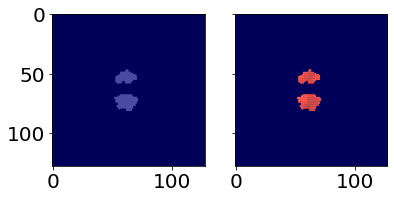

In [18]:
ind = np.argmax(dices)
plt.ioff()
camera = video_comparison([brains[ind][9], brains[ind][9]], 
                          [labels[ind], predicted_labels[ind]], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Use CRF

In [142]:
ind = np.argmax(dices)

label = predicted_masks[ind]
brain = brain_tensors[ind]
label_gt = real_masks[ind]
dice = dices[ind]

In [143]:
def to_tensor(array):
    return torch.tensor(np.expand_dims(array, axis=(0,1)))

In [144]:
DiceScoreBinary(to_tensor(label), 
                to_tensor(label_gt))

tensor(0.3648)

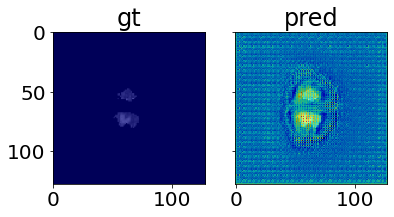

In [148]:
plt.ioff()

camera = video_comparison([brain,brain],
                             [label_gt, label],
                             titles=['gt','pred'])
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [149]:
# plt.ioff()
# camera = video(brain,
#                label, 
#               n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
plt.ioff()
camera = compare(brain,label_gt, 
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [37]:
import denseCRF3D

def densecrf3d(I, P, param):
    """
    input parameters:
        I: a numpy array of shape [D, H, W, C], where C is the channel number
           type of I should be np.uint8, and the values are in [0, 255]
        P: a probability map of shape [D, H, W, L], where L is the number of classes
           type of P should be np.float32
        param: a tuple giving parameters of CRF. see the following two examples for details.
    """
    return denseCRF3D.densecrf3d(I, P, param)


dense_crf_param = {}
dense_crf_param['MaxIterations'] = 1.0 #
dense_crf_param['PosW'] = 2.0 #
dense_crf_param['PosRStd'] = 1
dense_crf_param['PosCStd'] = 1
dense_crf_param['PosZStd'] = 1
dense_crf_param['BilateralW'] = 1.0
dense_crf_param['BilateralRStd'] = 1.0
dense_crf_param['BilateralCStd'] = 1.0
dense_crf_param['BilateralZStd'] = 1.0
dense_crf_param['ModalityNum'] = 1
dense_crf_param['BilateralModsStds'] = (1.0,)

brain_prep = (np.expand_dims(brain,-1)*255).astype('uint8')
label_prep = np.stack([1.0 - label, label], axis=-1)

label_crf = densecrf3d(brain_prep, label_prep, dense_crf_param)

Using addPairwiseBilateral for 1 Modality
MaxIterations :1
PosRStd       :1
PosCStd       :1
PosZStd       :1
PosW          :2
BilateralRStd :1
BilateralCStd :1
BilateralZStd :1
ModalityNum   :1
BilateralW    :1
BilateralModsStds:(1)


In [38]:
# plt.ioff()
# camera = video(brain,
#                label_crf, 
#               n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [41]:
label_gt.sum()

218.0

In [40]:
label_crf.sum()

4177

In [39]:
DiceScoreBinary(to_tensor(label_crf), 
                to_tensor(label_gt))

tensor(0.)

# Simple thresholding

In [83]:
label_thresh = label.copy()
thresh = 0.5
label_thresh[label_thresh >= thresh] = 1
label_thresh[label_thresh < thresh] = 0

In [131]:
mask = torch.load(val_dataloader.dataset.paths[ind])['mask']
mask = mask[mask.sum(dim=(1,2)) > 0][:,mask.sum(dim=(0,2)) > 0,:][:,:,mask.sum(dim=(0,1)) > 0]
mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).type(torch.float32),
                    config.interpolation_size).numpy()[0,0] > 0

In [132]:
label.sum() / label_gt.sum()

1.8643723

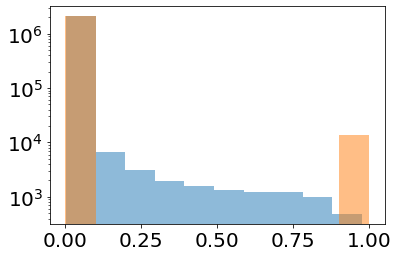

In [133]:
plt.hist(label.flatten(), alpha=0.5)
plt.hist(label_gt.flatten(), alpha=0.5)
plt.yscale('log')
plt.show()

In [134]:
DiceScoreBinary(to_tensor(label_thresh), 
                to_tensor(label_gt))

tensor(0.2977)

(array([7339., 1320.,  843.,  676.,  602.,  578.,  582.,  587.,  625.,
         481.]),
 array([0.00430274, 0.10139041, 0.19847809, 0.29556575, 0.39265344,
        0.48974112, 0.58682877, 0.68391645, 0.78100413, 0.8780918 ,
        0.9751795 ], dtype=float32),
 <BarContainer object of 10 artists>)

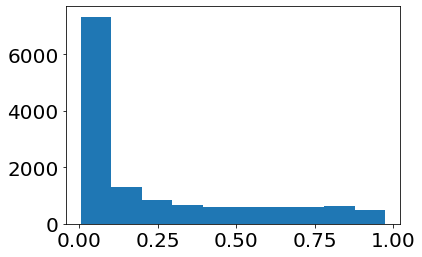

In [135]:
plt.hist(label[label_gt.astype('bool')])

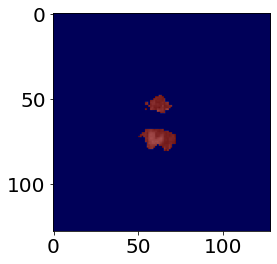

In [136]:
plt.ioff()
camera = video(brain,
               mask, 
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [139]:
dice

0.3648377060890198

In [141]:
DiceScoreBinary(to_tensor(label)*mask.astype('int'), 
                to_tensor(label_gt))

tensor(0.3662, dtype=torch.float64)

# Check geom. features concordance

In [53]:
brain_tensor_ = brain_tensor[0].detach().cpu().numpy()

In [22]:
plt.ioff()
camera = video_comparison(brain_tensor_, 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Check augmentation

In [62]:
brain_tensor_ = brain_tensor[0].detach().cpu().numpy()

symmetry = tio.RandomFlip(axes=0)
bias = tio.RandomBiasField(coefficients=0.3)
noise = tio.RandomNoise(std=(0,1e-3))
affine = tio.RandomAffine(scales=(0.9, 1.1, 0.9, 1.1, 0.9, 1.1), 
                         degrees=15,
                         translation=(1,1,1),
                         center='image',
                         default_pad_value=0)
rescale = tio.RescaleIntensity(out_min_max=(0, 1))
augmentation = tio.Compose([symmetry, bias, noise, affine, rescale]) # , affine

subject = tio.Subject(
            t1=tio.ScalarImage(tensor=brain_tensor_),
            diagnosis='positive'
        )

transformed = augmentation(subject)
brain_tensor_transformed = transformed['t1'].tensor.numpy()

In [88]:
# plt.imshow(brain_tensor_transformed[1,:,10,:])
# plt.colorbar()

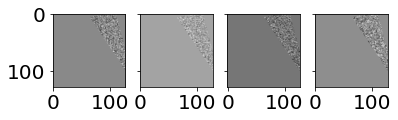

In [75]:
plt.ioff()
camera = video_comparison(brain_tensor_transformed)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation